## Hotel Cancellations (Originally from Kaggle Courses)
We will build a model to predict hotel cancellations with a binary classifier.

In [1]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('./hotel.csv')

X = hotel.copy() # Deep Copy 
y = X.pop('is_canceled')

In [3]:
X.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,342,2015,July,27,1,0,0,2,0.0,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,737,2015,July,27,1,0,0,2,0.0,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,7,2015,July,27,1,0,1,1,0.0,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,13,2015,July,27,1,0,1,1,0.0,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,14,2015,July,27,1,0,2,2,0.0,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: is_canceled, dtype: int64

In [5]:
# Mapping dates to numbers

X['arrival_date_month'] = X['arrival_date_month'].map({'January':1, 'February': 2, 'March':3,
                                                       'April':4, 'May':5, 'June':6, 'July':7,
                                                       'August':8, 'September':9, 'October':10,
                                                       'November':11, 'December':12})

In [6]:
# Defining features

features_num = ["lead_time", "arrival_date_week_number",
                "arrival_date_day_of_month", "stays_in_weekend_nights",
                "stays_in_week_nights", "adults", "children", "babies",
                "is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled", "required_car_parking_spaces",
                "total_of_special_requests", "adr"]

In [7]:
# Defining categorical features

features_cat = ["hotel", "arrival_date_month", "meal",
                "market_segment", "distribution_channel",
                "reserved_room_type", "deposit_type", "customer_type"]

In [8]:
# Transforming numerical and categorical features

transformer_num = make_pipeline(SimpleImputer(strategy="constant"), # there are a few missing values
                                StandardScaler())

transformer_cat = make_pipeline(SimpleImputer(strategy="constant", fill_value="NA"),
                                OneHotEncoder(handle_unknown='ignore'))

preprocessor = make_column_transformer((transformer_num, features_num),
                                       (transformer_cat, features_cat))

In [9]:
# stratify - make sure classes are evenlly represented across splits

X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]
print(input_shape)

[63]


## Defining a Model
The model will have both batch normalization and dropout layers.

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([layers.BatchNormalization(),
                          layers.Dense(256, activation='relu', input_shape=input_shape),
                          layers.BatchNormalization(),
                          layers.Dropout(rate=0.3),
                          layers.Dense(256, activation='relu'),
                          layers.BatchNormalization(),
                          layers.Dropout(rate=0.3),
                          layers.Dense(1, activation='sigmoid')])

<figure style="padding: 1em;">
<img src="NN_diagram.png" width="400">
</figure>

## Optimizer, Loss Function, and Accuracy Metric
We use Adam optimizer and binary versions of the cross-entropy loss and accuracy metric.

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

## Early stopping to prevent overfitting

In [12]:
early_stopping = keras.callbacks.EarlyStopping(patience=5,min_delta=0.001,restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=512,
                    epochs=200,
                    callbacks=[early_stopping])

Epoch 1/200
175/175 [==============================] - 3s 10ms/step - loss: 0.5533 - binary_accuracy: 0.7312 - val_loss: 0.4381 - val_binary_accuracy: 0.8044
Epoch 2/200
175/175 [==============================] - 1s 8ms/step - loss: 0.4311 - binary_accuracy: 0.7976 - val_loss: 0.4026 - val_binary_accuracy: 0.8138
Epoch 3/200
175/175 [==============================] - 1s 8ms/step - loss: 0.4133 - binary_accuracy: 0.8075 - val_loss: 0.3988 - val_binary_accuracy: 0.8138
Epoch 4/200
175/175 [==============================] - 1s 8ms/step - loss: 0.4009 - binary_accuracy: 0.8117 - val_loss: 0.3913 - val_binary_accuracy: 0.8175
Epoch 5/200
175/175 [==============================] - 1s 8ms/step - loss: 0.3978 - binary_accuracy: 0.8147 - val_loss: 0.3873 - val_binary_accuracy: 0.8209
Epoch 6/200
175/175 [==============================] - 1s 8ms/step - loss: 0.3906 - binary_accuracy: 0.8185 - val_loss: 0.3864 - val_binary_accuracy: 0.8213
Epoch 7/200
175/175 [==============================] - 1s

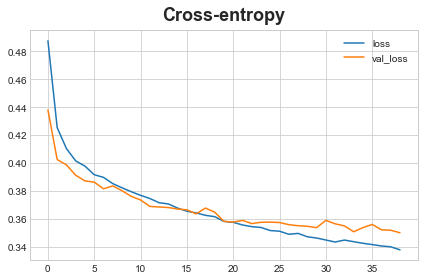

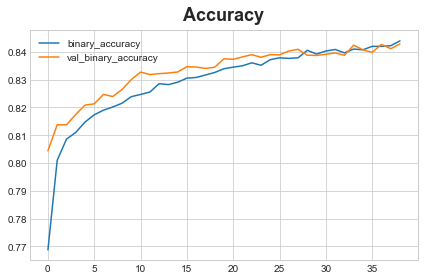

In [13]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")